# Semana 2: Ensambles, _Pasting_ y _Bagging_

# Árboles de decisión


El algoritmo de árboles de decisión se encuentra entre los más transparentes. Si bien por sí solos no son los algoritmos más poderosos, a partir de ellos pueden generarse algunos de los algoritmos más poderosos de aprendizaje automático, como veremos en esta y en las próximas clases.

## Recapitulando: Árboles aleatorios

Incluso con todos los valores de los hiperparámetros fijados, el árbol resultante no está definido de forma determinista. Es decir que dos corridas seguidas pueden producir árboles (ligeramente) diferentes. Esto es parecido a lo que pasaba con el **perceptrón** al comenzar desde valores de los pesos diferentes.

Pero acá el origen de la diferencia es otra. En cada división se realiza una barajada aleatoria de las características. Si hay dos divisiones que producen la misma reducción de impureza, se utilizará la primera y este orden relativo podría cambiar entre las ejecuciones. Por lo tanto, es posible que queramos establecer el `random_state` para obtener resultados reproducibles.

También podemos aleatorizar el resultado de nuestro árbol adrede. Esto será útil más adelante cuando consideremos conjuntos de árboles (en Random Forests). Los parámetros para aleatorizar el árbol resultante son

* `splitter`: Para cada característica, el algoritmo encuentra la mejor división y calcula su importancia (la reducción de impurezas), dada por el parámetro `criterion` (que puede ser `gini` o `entropy`). Si `splitter` se elije como `best`, se elige el mejor corte de la mejor característica. Si `splitter='random'`, se eligen cortes al azar para cada característica y se utiliza el mejor entre ellos.

* `max_features`: En cada división, se considera sólo un subconjunto aleatorio de características `max_features`. Las opciones son:

  * un int. Se consideran `max_features` características en cada división.
  * un float. `max_features` es una fracción y se consideran max(1, int(max_features * n_features_in_)) en cada división.
  * "auto". `max_features=sqrt(n_features)`.
  * "sqrt". `max_features=sqrt(n_features)`.
  * "log2". `max_features=log2(n_features)`.
  * "None". entonces `max_features=n_features`.

## Celdas preparatorias

In [ ]:
# Para que ande tanto en python 2 como en python 3
from __future__ import division, print_function, unicode_literals

# Importaciones comunes
import numpy as np
import os
import sys

import matplotlib.pyplot as plt
%matplotlib inline

# para hacer con que la salida de este notebook sea la misma en todas las ejecuciones
np.random.seed(42)

# Para hacer lindas gráficas
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Donde grabar las figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "02_RF"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignorara avisos inútiles (ver SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [ ]:
# Definamos un par de funciones útiles (si están en colab, caso contrário, tomarlas desde el módulo utils)
if 'google.colab' in sys.modules:

    def plot_clasi(x, t, ws, labels=[], xp=[-1., 1.], thr=[0,], spines='zero', equal=True,
                   join_centers=False, margin=None):
        """
        Figura con el resultado del ajuste lineal
        """
        assert len(labels) == len(ws) or len(labels) == 0
        assert len(ws) == len(thr)

        if margin is None:
            margin = [False] * len(ws)
        else:
            margin = np.atleast_1d(margin)
        assert len(margin) == len(ws)

        if len(labels) == 0:
            labels = np.arange(len(ws)).astype('str')

        # Agregemos el vector al plot
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111)

        xc1 = x[t == np.unique(t).max()]
        xc2 = x[t == np.unique(t).min()]

        ax.plot(*xc1.T, 'ob', mfc='None', label='C1')
        ax.plot(*xc2.T, 'or', mfc='None', label='C2')

        for i, w in enumerate(ws):

            # Calcula la norma del vector
            wnorm = np.sqrt(np.sum(w**2))

            # Ploteo vector de pesos
            x0 = 0.5 * (xp[0] + xp[1])
            ax.quiver(0, thr[i]/w[1], w[0]/wnorm, w[1]/wnorm,
                      color='C{}'.format(i+2), scale=10, label=labels[i],
                      zorder=10)

            # ploteo plano perpendicular
            xp = np.array(xp)
            yp = (thr[i] - w[0]*xp)/w[1]

            plt.plot(xp, yp, '-', color='C{}'.format(i+2))

            # Margen del plot
            if margin[i]:
                for marg in [-1, 1]:
                    ym = yp + marg/w[1]
                    plt.plot(xp, ym, ':', color='C{}'.format(i+2))


        if join_centers:
            # Ploteo de la línea que une centros de los conjuntos
            mu1 = xc1.mean(axis=1)
            mu2 = xc2.mean(axis=1)
            ax.plot([mu1[0], mu2[0]], [mu1[1], mu2[1]], 'o:k', mfc='None', ms=10)

        ax.legend(loc=0, fontsize=12)
        if equal:
            ax.set_aspect('equal')

        if spines is not None:
            for a in ['left', 'bottom']:
                ax.spines[a].set_position('zero')
            for a in ['top', 'right']:
                ax.spines[a].set_visible(False)

        return


    def makew(fitter):

        # # Obtengamos los pesos y normalicemos
        w = fitter.coef_.copy()

        # # Incluye intercept
        if fitter.fit_intercept:
            w = np.hstack([fitter.intercept_.reshape(1,1), w])

        # # Normalización
        #w /= np.linalg.norm(w)
        return w.T

else:
    from utils import plot_clasi

#de A. Gèron
def plot_decision_regions(clf, X, t, axes=None, npointsgrid=500, legend=False,
                          plot_training=True,
                          figkwargs={'figsize': [12, 8]},
                          contourkwargs={'alpha':0.3}, ax=None):
    """
    Plot decision regions produced by classifier.

    :param Classifier clf: sklearn classifier supporting XXX
    """

    if ax is None:
        fig = plt.figure(**figkwargs)
        ax = fig.add_subplot(111)

    if axes is None:
        dx = X[:, 0].max() - X[:, 0].min()
        dy = X[:, 1].max() - X[:, 1].min()
        axes = [X[:, 0].min() - 0.1*dx, X[:, 0].max() + 0.1*dx,
                X[:, 1].min() - 0.1*dy, X[:, 1].max() + 0.1*dy]

    # Define una rendija para las regiones
    x1s = np.linspace(axes[0], axes[1], npointsgrid)
    x2s = np.linspace(axes[2], axes[3], npointsgrid)
    x1, x2 = np.meshgrid(x1s, x2s)

    # Hacer predicciones de los puntos en la rendija; redefinir la forma de la rendija
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    #custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    ax.contourf(x1, x2, y_pred, **contourkwargs)

#     custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
#         plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)

    if plot_training:
        for label in np.unique(t):
            ax.plot(X[:, 0][t==label], X[:, 1][t==label], "o", label="C{}".format(label))

    # Ejes
    ax.set_xlabel(r"$x_1$", fontsize=18)
    ax.set_ylabel(r"$x_2$", fontsize=18, rotation=0)

    if legend:
        plt.legend(loc="lower right", fontsize=14)

    return


In [ ]:
# Función adaptada de A. Gèron
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, t, axes=[0, 7.5, 0, 3], is_iris=True,
                           legend=False, plot_training=True, ngridpoints=200,
                           alpha=1.0, ax=None):

    # Prepara los arreglos para colorear
    x1s = np.linspace(axes[0], axes[1], ngridpoints)
    x2s = np.linspace(axes[2], axes[3], ngridpoints)

    # los convierte en una grilla
    x1, x2 = np.meshgrid(x1s, x2s)

    # Calcula las predicciones sobre la grilla
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    if ax is None:
        ax = plt.figure().add_subplot(111)

    # Grafica con colores esa grilla
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

    if not is_iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        sct = ax.scatter(X[:,0], X[:, 1], c=t, edgecolors='k', s=9**2,
                  cmap=plt.cm.rainbow, alpha=alpha)

        # plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        # plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        # plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        # plt.axis(axes)
    if is_iris:
        legend1 = ax.legend(sct.legend_elements()[0], iris.target_names,
                            loc="upper left", title="Clases")
        ax.add_artist(legend1)

        ax.set_xlabel("Largo del pétalo", fontsize=16)
        ax.set_ylabel("Ancho del pétalo", fontsize=16)
    else:
        ax.set_xlabel(r"$x_1$", fontsize=18)
        ax.set_ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        ax.legend(loc="lower right", fontsize=14)

## Sigamos con el conjunto de datos "lunas" (_moons_)

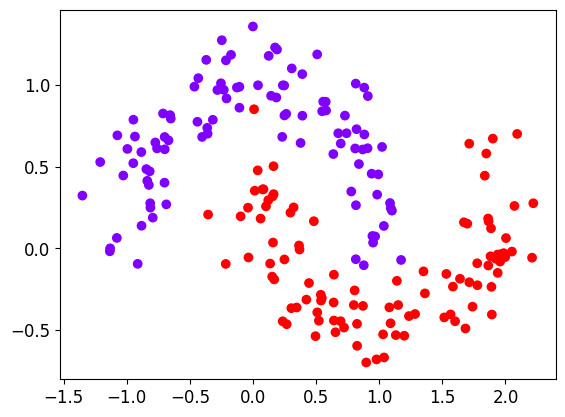

In [ ]:
from sklearn.datasets import make_moons
X, t = make_moons(n_samples=200, noise=0.15, random_state=42)

plt.scatter(X[:,0], X[:,1], c=t+5, cmap='rainbow')

In [ ]:
tree_clf_luna = DecisionTreeClassifier(max_depth=5, min_samples_leaf=3)


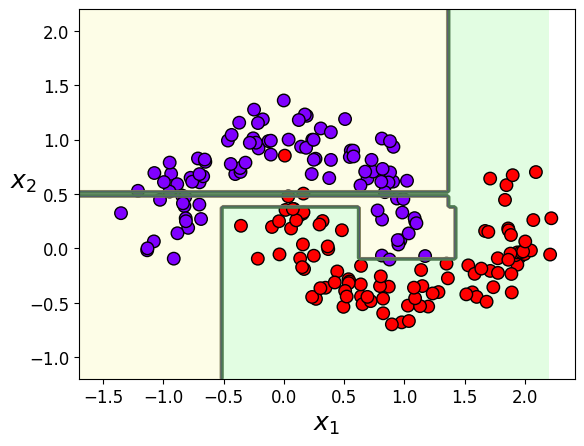

In [ ]:
tree_clf_luna.fit(X, t)
plot_decision_boundary(tree_clf_luna, X, t,
                        is_iris=False, axes=[-1.7, 2.2, -1.2, 2.2])

### Paréntesis repaso evaluación

In [ ]:
## Evaluación correcta!

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_clf_luna, X, t, cv=5, scoring='accuracy')

In [ ]:
scores

array([1.   , 0.95 , 0.95 , 0.975, 0.925])

In [ ]:
print(scores.mean())
print(scores.std())

0.96
0.025495097567963917


In [ ]:
## ¡LO QUE NO HAY QUE HACER!
from sklearn.metrics import accuracy_score

pred = tree_clf_luna.predict(X)
accuracy_score(t, pred)

0.99

### Volvemos a los árboles aleatorios

In [ ]:
tree_clf_random = DecisionTreeClassifier(max_depth=5, splitter='best', max_features=1)

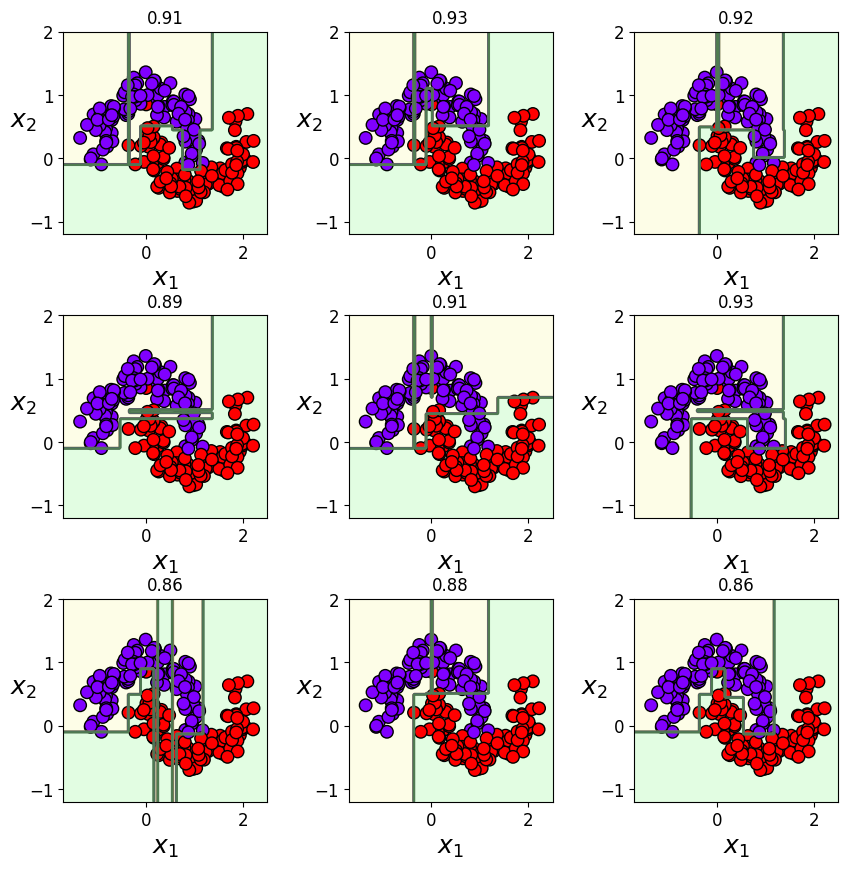

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    tree_clf_random.fit(X, t)
    ax = fig.add_subplot(3, 3, i+1)
    plot_decision_boundary(tree_clf_random, X, t,
                           is_iris=False, axes=[-1.7, 2.5, -1.2, 2.], ax=ax, legend=False)
    score_medio = cross_val_score(tree_clf_random, X, t, cv=5, scoring='accuracy').mean()
    ax.set_title('{:.2f}'.format(score_medio))

plt.subplots_adjust(hspace=0.4, wspace=0.4)

plt.show()

### Extra aleatorios

In [ ]:
tree_clf_extrarandom = DecisionTreeClassifier(max_depth=5, splitter='random', max_features=1)


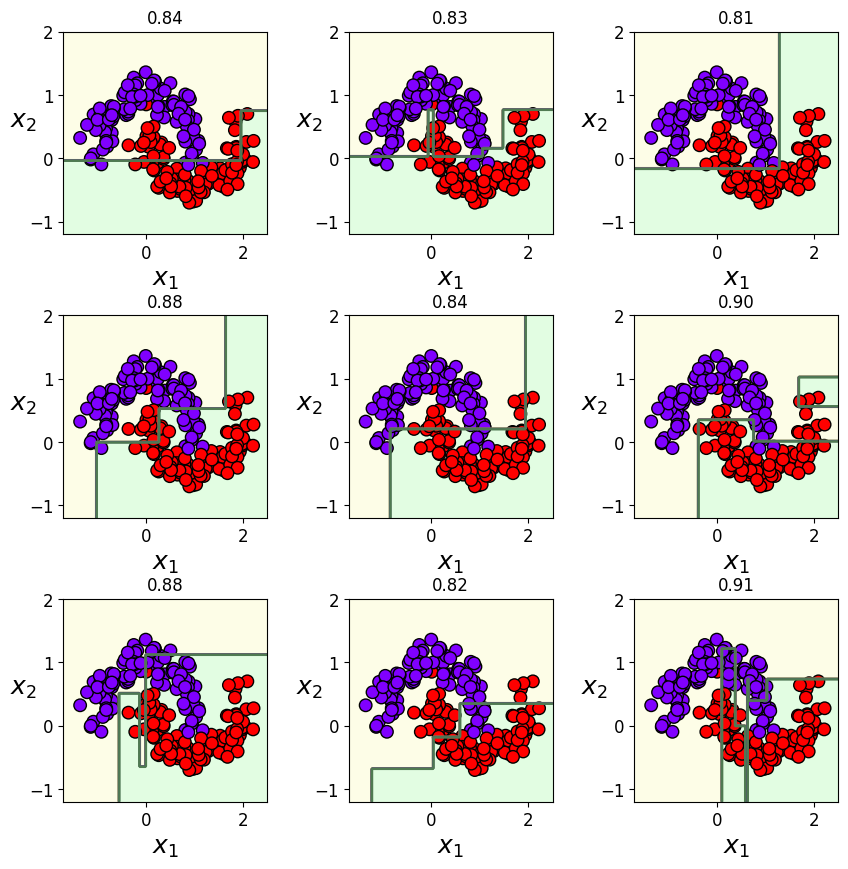

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    tree_clf_extrarandom.fit(X, t)
    ax = fig.add_subplot(3, 3, i+1)
    plot_decision_boundary(tree_clf_extrarandom, X, t,
                           is_iris=False, axes=[-1.7, 2.5, -1.2, 2.], ax=ax, legend=False)
    score_medio = cross_val_score(tree_clf_extrarandom, X, t, cv=5, scoring='accuracy').mean()
    ax.set_title('{:.2f}'.format(score_medio))

plt.subplots_adjust(hspace=0.4, wspace=0.4)

plt.show()

## ExtraTrees

El algoritmo ExtraTrees (de _extremelly Randomized Trees_) es un método de _ensemble_ que usa **todo el conjunto de datos** y muchos árboles de decisión con sepraraciones aleatorias entre nodos.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier # observar que estamos importando de *ensemble*

In [ ]:
etc = ExtraTreesClassifier(n_estimators=100, max_depth=7, max_features=1)

In [ ]:
etc.fit(X, t)

ExtraTreesClassifier(max_depth=7, max_features=1)

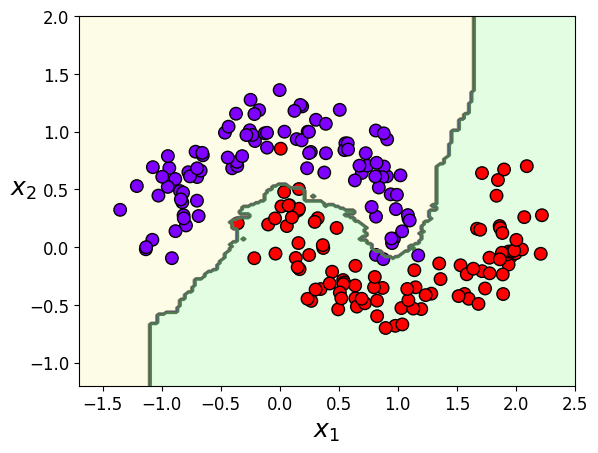

In [ ]:
plot_decision_boundary(etc, X, t,
                        is_iris=False, axes=[-1.7, 2.5, -1.2, 2.], legend=False)

In [ ]:
scores_rf = cross_val_score(etc, X, t, cv=5, scoring='accuracy')

In [ ]:
print(scores_rf.mean())

0.9650000000000001


# Ensembles: combinación de modelos para mejorar el desempeño

Comités
* Combinar modelos, que podrían ser malos aprendices individualmente, para producir un mejor resultado.
* A diferencia de los árboles de decisión (DT), los miembros del comité producen predicciones de las mismas regiones del espacio de características, y son sus resultados los que se combinan.
* Los modelos que combinamos pueden ser el mismo modelo actuando en diferentes conjuntos de datos, o diferentes tipos de modelos, o una combinación de ambos

Combinando predicciones
* Regresión:
   * promedio de las predicciones del modelo
* Clasificación:
   * moda de la distribución (clase más votada)
   * moda pesada (si se proporciona una probabilidad)

## **Conjunto de datos de lunas**

Volvamos a utilizar la función `make_moons` para producir un conjunto de datos no linealmente separables en dos dimensiones (lo que nos permitirá visualizar gráficamente las cosas).

In [ ]:
from sklearn.datasets import make_moons
X, t = make_moons(n_samples=400, noise=0.25, random_state=1234)

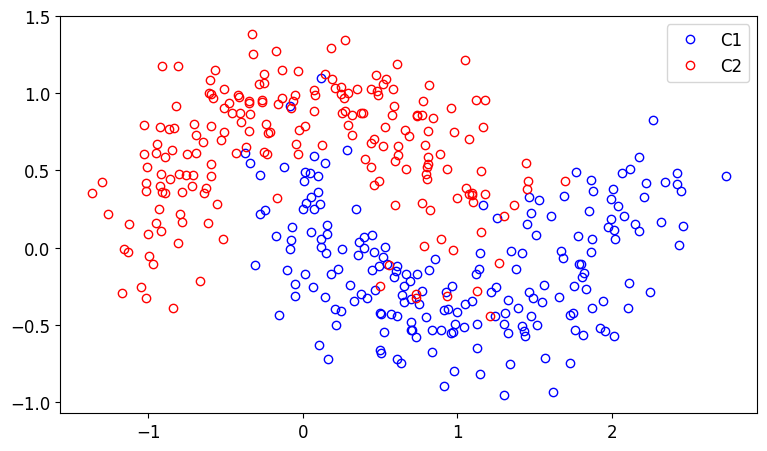

In [ ]:
plot_clasi(X, t, [], [], [], [], spines=None)

In [ ]:
from sklearn.model_selection import train_test_split

# Split
X, X_test, t, t_test = train_test_split(X, t, test_size=0.2) # ¡ojo con la notación!

In [ ]:
# from sklearn.model_selection import train_test_split

# Split
X, X_test, t, t_test = train_test_split(X, t, test_size=0.2) # ¡ojo con la notación!

## El poder de la aleatoriedad

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Fit many times
dts = []
for i in range(9):
    dt = DecisionTreeClassifier()
    dts.append(dt.fit(X, t))

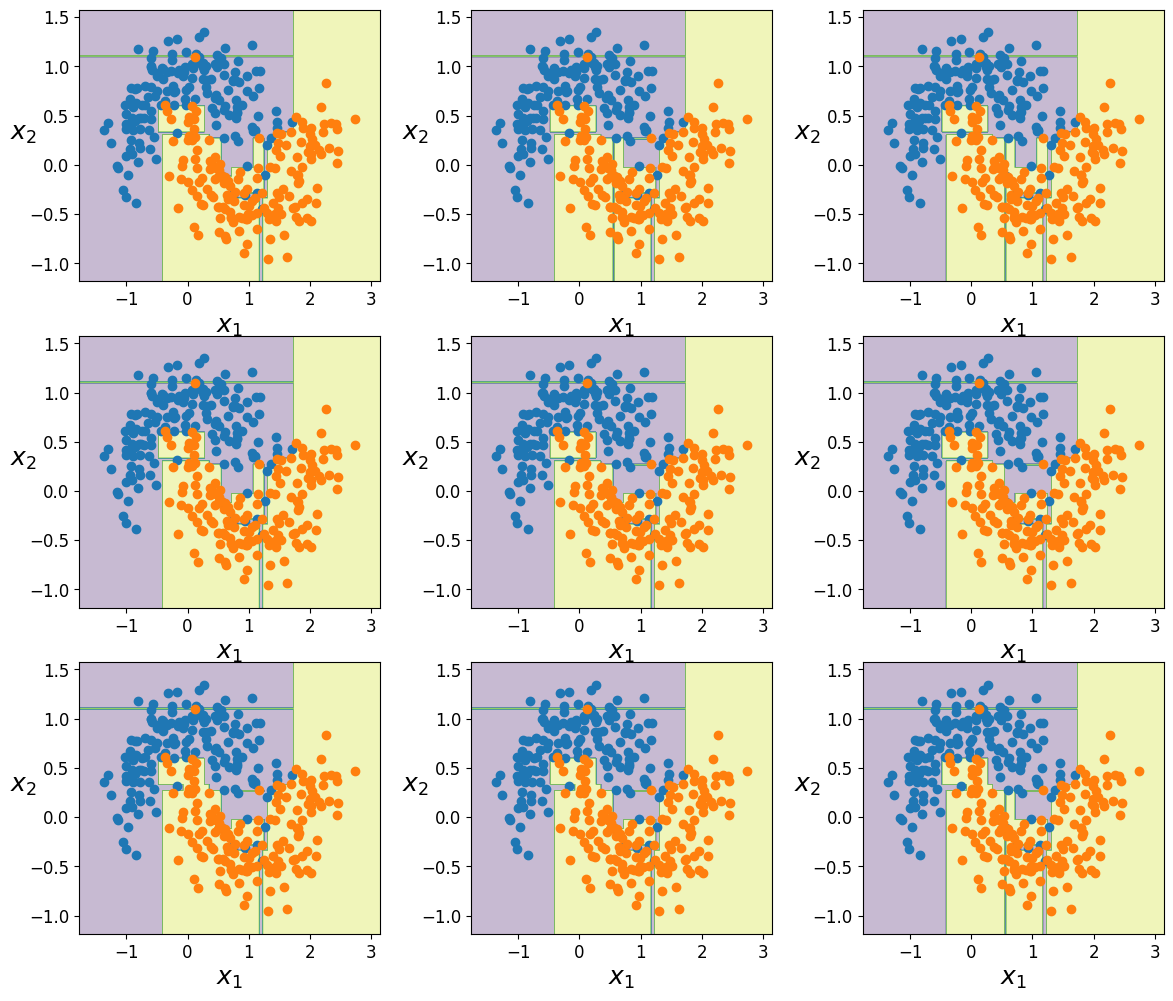

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(14, 12), gridspec_kw={'wspace': 0.3})

for i, ax in enumerate(axs.flatten()):
    plot_decision_regions(dts[i], X, t, ax=ax)

In [ ]:
from sklearn.tree import ExtraTreeClassifier # observar que estamos importando de tree

# Fit many times
ets = []
for i in range(9):
    et = ExtraTreeClassifier()
    ets.append(et.fit(X, t))

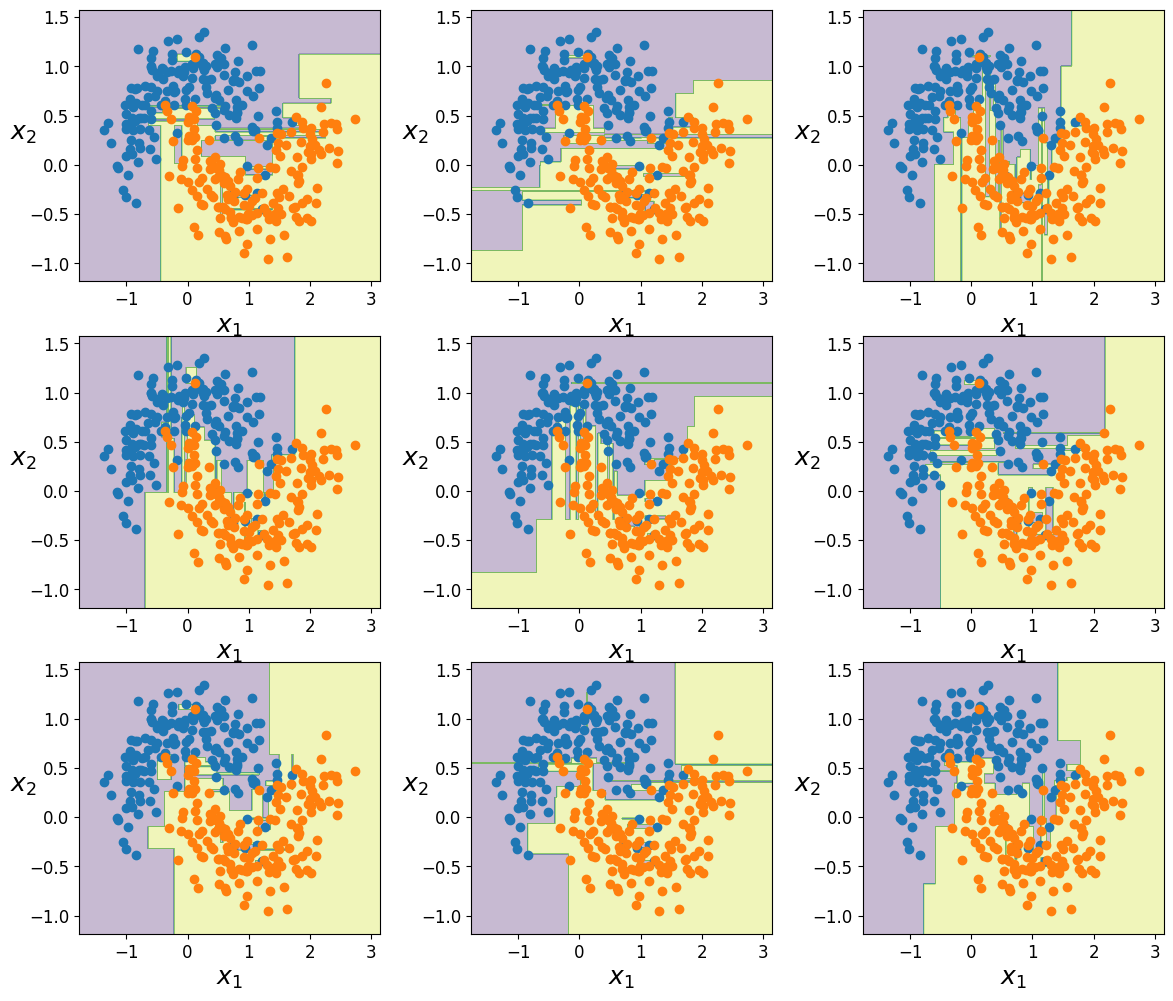

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(14, 12), gridspec_kw={'wspace': 0.3})

for i, ax in enumerate(axs.flatten()):
    plot_decision_regions(ets[i], X, t, ax=ax)

## Entrenamiento simple de una *Random Forest*

In [ ]:
from sklearn.model_selection import train_test_split

# Split
X, X_test, t, t_test = train_test_split(X, t, test_size=0.2) # ¡ojo con la notación!

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=6)
rf.fit(X, t)

RandomForestClassifier(n_jobs=6)

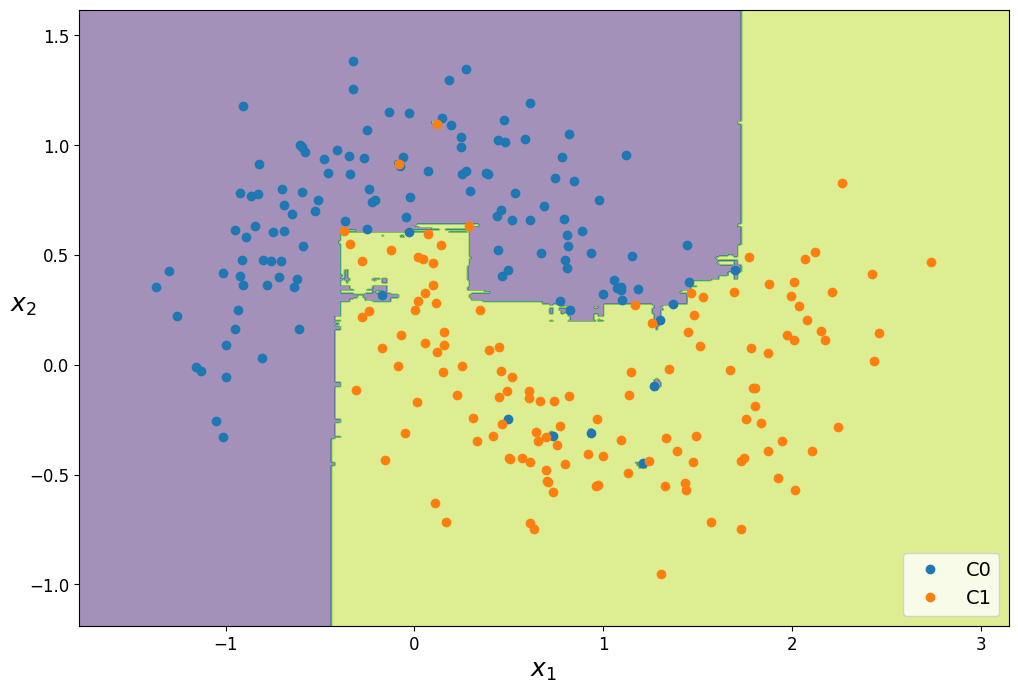

In [ ]:
fig = plot_decision_regions(rf, X, t, legend=True, npointsgrid=500,
                            figkwargs={'figsize': [12, 8]},
                            contourkwargs={'alpha':0.5, 'levels':5, 'cmap':'viridis'})

# **Este es claramente un modelo con un poder de generalización débil**

In [ ]:
from sklearn.metrics import accuracy_score

y_train = rf.predict(X)
y_test = rf.predict(X_test)
print('Accuracy (train): {:.3f}'.format(accuracy_score(t, y_train)))
print('Accuracy (test): {:.3f}'.format(accuracy_score(t_test, y_test)))

Accuracy (train): 1.000
Accuracy (test): 0.953


## Evaluación fuera de la bolsa / *Out of bag evaluation*

En el *bagging*, los estimadores base individuales se entrenan sólo en una porción del conjunto de entrenamiento, lo que nos permite evaluar su rendimiento en los demás puntos no utilizados, para estimar la generalización de forma similar a la validación cruzada. Comparemos las diferencias con la puntuación obtenida mediante validación cruzada:

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X, t, scoring='accuracy')
print(f"Cross Validation Accuracy: {scores.mean():.2f} +/- {scores.std():.2f}")

Cross Validation Accuracy: 0.90 +/- 0.06


Si queremos usar esta puntuación *fuera de bolsa*, tenemos que decírselo al modelo antes de que ajuste los datos usando el parámetro `oob_score`, para que el *score* de validación sea calculado y almacenado.

In [ ]:
rf_oob = RandomForestClassifier(n_estimators=100, n_jobs=6, oob_score=True)
rf_oob.fit(X, t)

RandomForestClassifier(n_jobs=6, oob_score=True)

In [ ]:
print(f"Out-of-Bag Accuracy:{rf_oob.oob_score_:.2f}")

Out-of-Bag Accuracy:0.93


El *score* oob parece estar bastante cerca de la puntuación media de la validación cruzada. Sin embargo, vemos que no es lo mismo, ya que la validación cruzada entrena en diferentes rodadas cada vez con un conjunto de datos que es diferente del conjunto completo de entrenamiento, y proporciona varios *scores* que nos permiten calcular un promedio y también una dispersión.

## _Bagging_ y _Pasting_

Podemos obtener un comité de estimadores diferentes a partir de un único estimador base, si lo entrenamos en distintos conjuntos de datos. La generación de diferentes conjuntos de datos mediante la selección aleatoria de muestras o características se codifica en el `BaggingClassifier` y `BaggingRegressor` de sklearn. Este algoritmo engloba varios métodos de la literatura:
* Cuando los conjuntos de datos se generan mediante un submuestreo aleatorio (sin reemplazo) del conjunto de entrenamiento, entonces este algoritmo se conoce como *Pasting*.
* Si las muestras se extraen con reemplazo, el método se conoce como *Bagging*.
* Cuando seleccionamos aleatoriamente un subconjunto de _características_, el método se conoce como "subespacios aleatorios" (*Random Subspaces*).
* Cuando los estimadores base se construyen sobre subconjuntos tanto de muestras como de características, entonces el método se conoce como Parches Aleatorios (*Random Patches*).

Hagamos un clasificador de _bagging_ (con reemplazo, es decir, `bootstrap=True`) a partir de un ExtraTree (un árbol extremadamente aleatorio, que utiliza el mejor corte aleatorio entre un subconjunto de características). Cada ExtraTree se entrenará con un conjunto de 100 muestras cada uno, tomadas al azar del conjunto de entrenamiento.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import ExtraTreeClassifier

bag_clf = BaggingClassifier(
    ExtraTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X, t)
y_pred = bag_clf.predict(X_test)

El BaggingClassifier posee todos los métodos habituales de cualquier estimador sklearn, como `.fit` y `.predict`. Calculemos su precisión en el conjunto de pruebas

0.96875


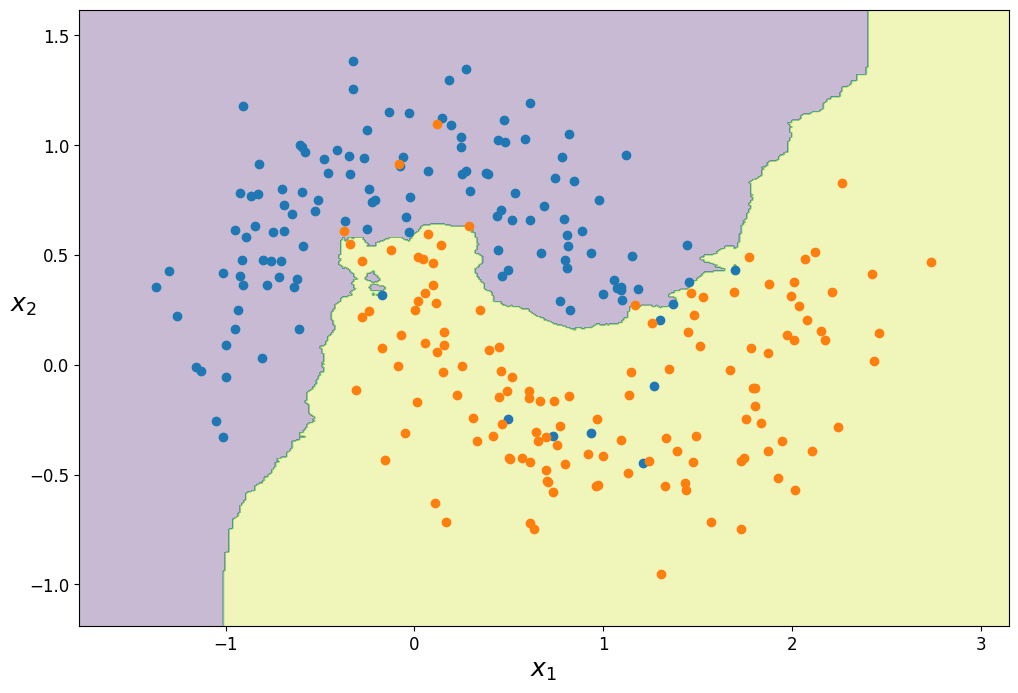

In [ ]:
print(accuracy_score(t_test, y_pred))
plot_decision_regions(bag_clf, X, t)
plt.show()

Para compararlo con el rendimiento del estimador de base única, vamos a entrenar un ExtraTree igual que el utilizado como estimador de base:

0.921875


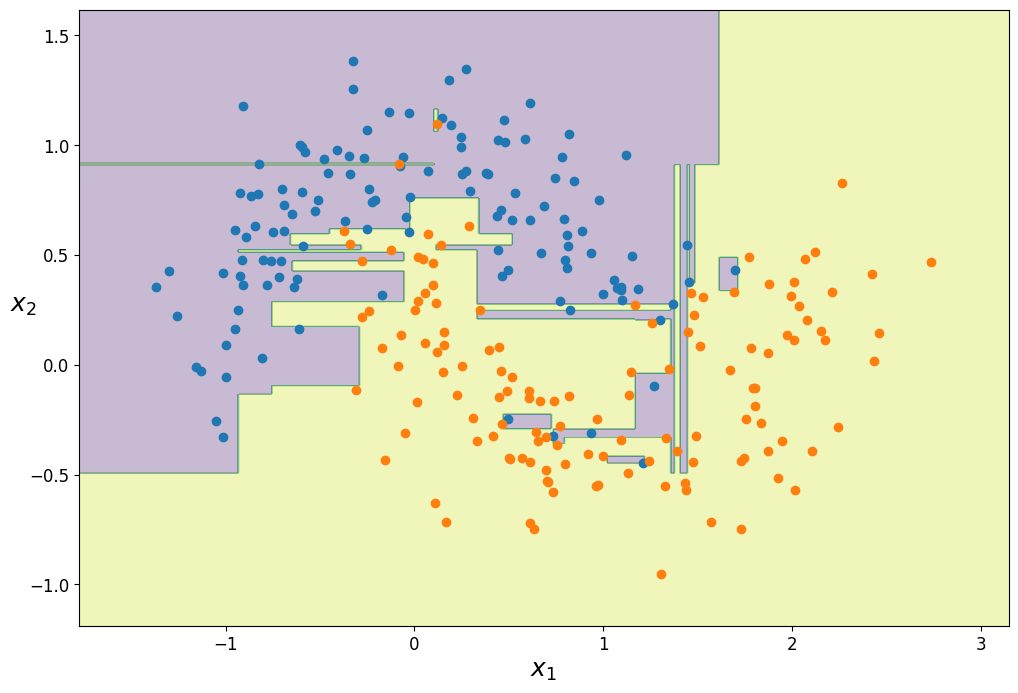

In [ ]:
tree_clf = ExtraTreeClassifier(random_state=42)
tree_clf.fit(X, t)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(t_test, y_pred_tree))
plot_decision_regions(tree_clf, X, t)
plt.show()

Este árbol único sobrajusta claramente a los datos. Este sobreajuste de cada estimador base, que también significa una alta varianza de los datos, se *promedia* en el clasificador de _bagging_ dando una superficie de decisión que probablemente generalizará mejor a los nuevos datos.

Los distintos enfoques se pueden implementar utilizando los argumentos:

* `bootstrap`. Si es verdadero, se hará un muestreo con reemplazo (es decir, *Bagging*), si no *Pasting*.
* `max_samples`. Permite limitar el número de muestras en cada conjunto de datos aleatorios (int o fracción del conjunto de entrenamiento).
* `max_features`. Permite la implementación de Subespacios aleatorios (`Random Subspaces`) y Parches aleatorios (`Random Patches`). Por defecto es 1.0, es decir, utiliza todas las características.
* `bootstrap_features`. Determina si las características se toman también con reemplazo.